In [42]:
import pandahouse as ph
import seaborn as sns
import numpy as np
import plotly as plt

In [4]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [5]:
connection_test = dict(database='test',
                  host='http://clickhouse.beslan.pro:8080',
                  user='student-rw',
                  password='656e2b0c9c')

In [82]:
q = '''
    SELECT 
        id,
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
        toFloat32OrNull(review_scores_rating) AS scores_rating
        
    FROM 
        ldn_listings
    WHERE
    scores_rating != 0
    ORDER BY
        id ASC
        
    LIMIT 1000
    
    '''

In [83]:
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,id,room_type,price,scores_rating
0,13913,Private room,65.0,97.0
1,15400,Entire home/apt,100.0,96.0
2,17402,Entire home/apt,300.0,94.0
3,25023,Entire home/apt,65.0,93.0
4,25123,Private room,29.0,96.0
...,...,...,...,...
995,616278,Entire home/apt,165.0,100.0
996,617678,Private room,99.0,93.0
997,618082,Private room,45.0,100.0
998,619010,Private room,20.0,88.0


In [86]:
df = q_test.groupby('room_type', as_index = False) \
    .mean()
df.head()

,room_type,id,price,scores_rating
0,Entire home/apt,384903.108830,135.882950,93.568787
1,Hotel room,65525.000000,134.000000,92.500000
2,Private room,383590.166994,54.642437,94.766205
3,Shared room,474893.500000,21.000000,90.000000


In [90]:
df[df['room_type'] == 'Private room']

,room_type,id,price,scores_rating
2,Private room,383590.166994,54.642437,94.766205


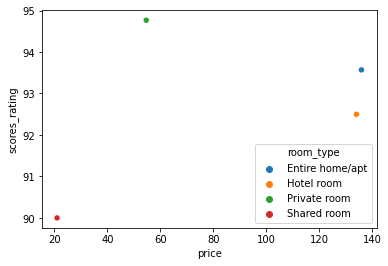

In [89]:
sns.scatterplot(data=df, x='price', y='scores_rating', hue='room_type')

In [110]:
q = '''
    SELECT
       DISTINCT host_id as host_id, host_verifications
   FROM
       {db}.ldn_listings
       where experiences_offered != 'none'
       '''

In [111]:
q_test_2 = ph.read_clickhouse(query=q, connection=connection_default)
q_test_2

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [112]:
q_test_2['host_verifications'] = q_test_2['host_verifications'].apply(lambda x: x.strip('[,]').split(','))
# .apply(lambda x: x.strip('[]').replace("'", '').split(', ')) в разборе
q_test_2.head()

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', ..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'go..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'gov..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio..."
4,103583,"['email', 'phone', 'reviews', 'offline_gove..."


In [103]:
q_test_2.explode('host_verifications')['host_verifications'].value_counts().to_frame(name='count')

,count
'email',1345
'phone',1345
'reviews',1309
'government_id',1196
'jumio',1115
'offline_government_id',469
'work_email',279
'facebook',270
'selfie',252
'identity_manual',227


In [14]:
q_exp = '''
    SELECT
        neighbourhood_cleansed,
        experiences_offered,
        COUNT(*) AS experiences_count
    FROM ldn_listings
    WHERE experiences_offered != 'none'
    GROUP BY
        neighbourhood_cleansed,
        experiences_offered
    
    ORDER BY experiences_count DESC
    LIMIT 100
    '''

In [18]:
df_exp = ph.read_clickhouse(query=q_exp, connection=connection_default)
df_exp.head()

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48


In [20]:
df_exp_pivot = df_exp.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')
df_exp_pivot.head()

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0


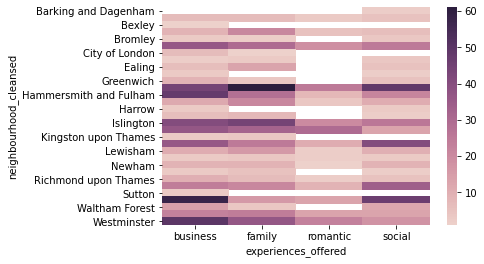

In [21]:
sns.heatmap(df_exp_pivot, cmap=sns.cubehelix_palette(as_cmap=True))

In [22]:
q_graf = '''
    SELECT
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
    FROM ldn_listings
    WHERE experiences_offered != 'none'
    '''

In [23]:
df_graf = ph.read_clickhouse(query=q_graf, connection=connection_default)
df_graf.head()

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0


In [28]:
df_graf['price_log'] = np.log(df_graf.price)

In [39]:
df_graf.room_type.unique()

array(['Private room', 'Entire home/apt', 'Hotel room', 'Shared room'],
      dtype=object)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


AttributeError: module 'plotly' has no attribute 'legend'

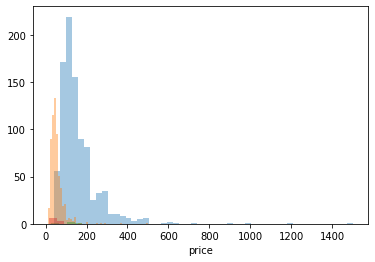

In [48]:
sns.distplot((df_graf.query("room_type == 'Entire home/apt'").price), kde=False, label='Entire home/apt')
sns.distplot((df_graf.query("room_type == 'Private room'").price), kde=False, label='Private room')
sns.distplot((df_graf.query("room_type == 'Hotel room'").price), kde=False, label='Hotel room')
sns.distplot((df_graf.query("room_type == 'Shared room'").price), kde=False, label='Shared room')


plt.legend()
plt.show()

In [121]:
q_last = '''
    SELECT
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
        first_review
    FROM ldn_listings
    
    WHERE first_review > '2010-01-01'
    
    LIMIT 1000
    '''

In [124]:
df_last = ph.read_clickhouse(query=q_last, connection=connection_default)
df_last.head()

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16


In [125]:
df_last.first_review = df_last.first_review.apply(lambda x: x[:-6])
df_last.head()

,room_type,price,first_review
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010


In [135]:
df_last_avg = df_last.groupby(['room_type', 'first_review'], as_index=False) \
    .agg({'price' : 'mean'}) \
    .sort_values('first_review')
df_last_avg.head()

,room_type,first_review,price
0,Entire home/apt,2010,103.500000
13,Private room,2010,56.428570
11,Hotel room,2010,88.000000
1,Entire home/apt,2011,128.792450
14,Private room,2011,52.607143


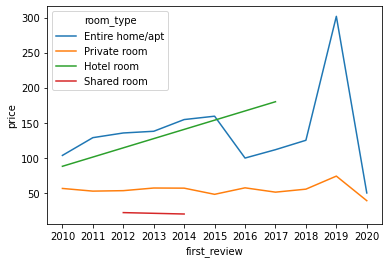

In [137]:
sns.lineplot(data=df_last_avg, x='first_review', y='price', hue='room_type')